# Семинар 3. Обучение сверточных нейросетей в Pytorch

На этом семинаре мы будем обучать LeNet-5 на данных MNIST (и не только :). Мы наконец перестанем реализовывать все самостоятельно и будем пользоваться готовым функционалом pytorch.

Для начала ознакомимся с парой примеров обучения модели:
* [Пример 1](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py)
* [Пример 2](https://github.com/jcjohnson/pytorch-examples/blob/master/nn/two_layer_net_nn.py)

### Загрузка данных в pytorch

In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.utils.data

In [38]:
from matplotlib import pyplot as plt
%matplotlib inline

В этот раз мы будем работать MNIST: он отличается от digits разрещением изображений (28x28 вместо 8x8) и числом объектов (60000 в обучении вместо 1797). 

В pytorch есть своя обертка, позволяющая скачивать MNIST, но нам будет удобнее скачать его самостоятельно.

In [39]:
from util import load_mnist

In [40]:
X_train, y_train, X_test, y_test = load_mnist()

Помимо обучающей и контрольной, нам понадобится валидационная выборка, чтобы настраивать гиперпараметры. Ее можно отделить от обучающей выборки (например, 25% = 15000 объектов). Однако модель несколько долго обучается даже на 75% обучающей выборки (несколько минут), что не очень хорошо для семинара. Поэтому для валидационных целей предлагается обучающую выборку также сжать до 15000 объектов. Финальную модель будем обучать по всей выборке.

In [41]:
# shuffle data
np.random.seed(0)
idxs = np.random.permutation(np.arange(X_train.shape[0]))
X_train, y_train = X_train[idxs], y_train[idxs]
                            
X_train.shape

(60000, 1, 28, 28)

В pytorch есть удобный класс для генерации батчей - DataLoader. Ему на вход надо подать объект класса TensorDataset, слудащий оберткой над матрицами данных.

In [65]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), 
                                       torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train, 
                                               batch_size=batch_size)
    return train_loader

# for final model:
train_loader_full = get_loader(X_train, y_train) 
test_loader = get_loader(X_test, y_test)
# for validation purposes:
train_loader = get_loader(X_train[:15000], y_train[:15000])
val_loader = get_loader(X_train[15000:30000], y_train[15000:30000])

In [66]:
# check number of objects
val_loader.dataset.tensors[0].shape

torch.Size([15000, 1, 28, 28])

### Задание модели LeNet-5

Сверточный слой (из презентации Антона Осокина):
![Слайд про свертки из презентации Антона Осокина](https://github.com/nadiinchi/dl_labs/raw/master/convolution.png)

Нам надо реализовать LeNet-5:

![Архитектура LeNet-5](https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x64257)

Соберите нейросеть в соответствии с изображениями и примерами кода, которые были даны выше. В качестве нелинейности используйте ReLU (после всех сверточных и полносвязных слоев). Кроме того, нейросеть должна поддерживать увеличение числа сверток во всех сверточных слоях в k раз. 

Обратите внимание, что на схеме вход имеет размерность 32x32, а у нас - 28x28 (см. ячейку выше). Применять софтмакс в конце прохода вперед не нужно.

In [1]:
class CNN(nn.Module):
    def __init__(self, k=1):
        super(CNN, self).__init__()
        ### your code here: define layers
        self.conv1 = nn.Conv2d(1, 6*k, kernel_size=5)
        self.conv2 = nn.Conv2d(6*k, 16*k, kernel_size=5)
        self.fc1 = nn.Linear(4*4*16*k, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        ### your code here: transform x using layers
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

NameError: name 'nn' is not defined

Посчитаем параметры нейросети:

In [68]:
cnn = CNN()

In [69]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

count_parameters(cnn)

44426

### Обучение нейросети

Определим функцию потерь:

In [70]:
criterion = nn.CrossEntropyLoss(size_average=False) # loss includes softmax

/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Также определим устройство, на котором будем хранить данные и модель (cpu или gpu), и перенем на него модель:

In [71]:
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU
cnn = cnn.to(device)

Во время обучения модели удобно контролировать качество и на обучении, и на контроле (валидации) - возникает дублирующий код. Поэтому мы вынесем в отдельную функцию оценку модели, и в отдельную функцию - эпоху обучения. Это позволит также честно оценивать значение критерия качества на всей обучающей выборке по окончании эпохи (а не усреднять значения на минибатчах).

В прототипах указано про train и eval mode: в нашем случае они не нужны (были бы нужны, если бы мы использовали дропаут или батч-нормализацию, к примеру). Но чтобы вы могли использовать этот код в будущем, лучше указывать переключение режима.

In [72]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    """
    for each batch 
    performs forward and backward pass and parameters update 
    
    Input:
    model: instance of model (example defined above)
    optimizer: instance of optimizer (defined above)
    train_loader: instance of DataLoader
    
    Returns:
    nothing
    
    Do not forget to set net to train mode!
    """
    ### your code here
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def evaluate_loss_acc(loader, model, criterion, device):
    """
    Evaluates loss and accuracy on the whole dataset
    
    Input:
    loader:  instance of DataLoader
    model: instance of model (examle defined above)
    
    Returns:
    (loss, accuracy)
    
    Do not forget to set net to eval mode!
    """
    ### your code here
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        loss = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()
            loss += criterion(outputs, labels)
        accuracy = correct / total
        loss = loss / total
        return (loss, accuracy)
        
        
    
    
def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True):
    """
    Performs training of the model and prints progress
    
    Input:
    model: instance of model (example defined above)
    opt: instance of optimizer 
    train_loader: instance of DataLoader
    test_loader: instance of DataLoader (for evaluation)
    n_epochs: int
    
    Returns:
    4 lists: train_log, train_acc_log, val_log, val_acc_log
    with corresponding metrics per epoch
    """
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader, model, criterion, device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model, criterion, device)

        train_log.append(train_loss)
        train_acc_log.append(train_acc)

        val_log.append(val_loss)
        val_acc_log.append(val_acc)
        
        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))
            
    return train_log, train_acc_log, val_log, val_acc_log

Обучите нейронную сеть, используя определенные функции. Установите Adam в качестве оптимизатора, learning_rate=0.001, число эпох - 20. В качестве test_loader используйте валидационную выборку.

In [73]:
### your code here
learning_rate = 0.001
num_epochs = 20
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
train_log, train_acc_log, val_log, val_acc_log = train(cnn, optimizer, train_loader, \
                                                       val_loader, criterion, num_epochs, \
                                                       device, verbose=True)

Epoch [1/20], Loss (train/test): 0.2684/0.2838, Acc (train/test): 0.9219/0.9193
Epoch [2/20], Loss (train/test): 0.1463/0.1665, Acc (train/test): 0.9563/0.9511
Epoch [3/20], Loss (train/test): 0.1043/0.1294, Acc (train/test): 0.9679/0.9616
Epoch [4/20], Loss (train/test): 0.0855/0.1140, Acc (train/test): 0.9723/0.9654
Epoch [5/20], Loss (train/test): 0.0802/0.1122, Acc (train/test): 0.9737/0.9671
Epoch [6/20], Loss (train/test): 0.0844/0.1187, Acc (train/test): 0.9729/0.9647
Epoch [7/20], Loss (train/test): 0.0622/0.1002, Acc (train/test): 0.9795/0.9712
Epoch [8/20], Loss (train/test): 0.0542/0.0962, Acc (train/test): 0.9822/0.9722
Epoch [9/20], Loss (train/test): 0.0434/0.0931, Acc (train/test): 0.9855/0.9733
Epoch [10/20], Loss (train/test): 0.0357/0.0914, Acc (train/test): 0.9877/0.9733
Epoch [11/20], Loss (train/test): 0.0256/0.0838, Acc (train/test): 0.9913/0.9760
Epoch [12/20], Loss (train/test): 0.0227/0.0864, Acc (train/test): 0.9931/0.9769
Epoch [13/20], Loss (train/test): 0.0

Визуализируем результат прохождения изображения через слои. Код ниже отрисовывает сетку изображений: первый столбец - изображения цифр, следующие 6 столбцов - результаты применения фильтров к ним. Чтобы им воспользоваться, сохраните в x переменную, храняющую батч из 10 изображений, в y - результат применения первого слоя к x.

In [74]:
### your code here
x = torch.from_numpy(X_train[:10]).to(device)
cnn.eval()
y = cnn.conv1(x)

In [75]:
def plot(x, y):
    plt.figure(figsize=(15, 15))
    for im in range(10):
        plt.subplot(11, 7, im*7+1)
        plt.imshow(x.data[im, 0])
        plt.axis("off")
        for i in range(6):
            plt.subplot(11, 7, im*7+i+2)
            plt.imshow(y.data[im, i].numpy())
            plt.axis("off")

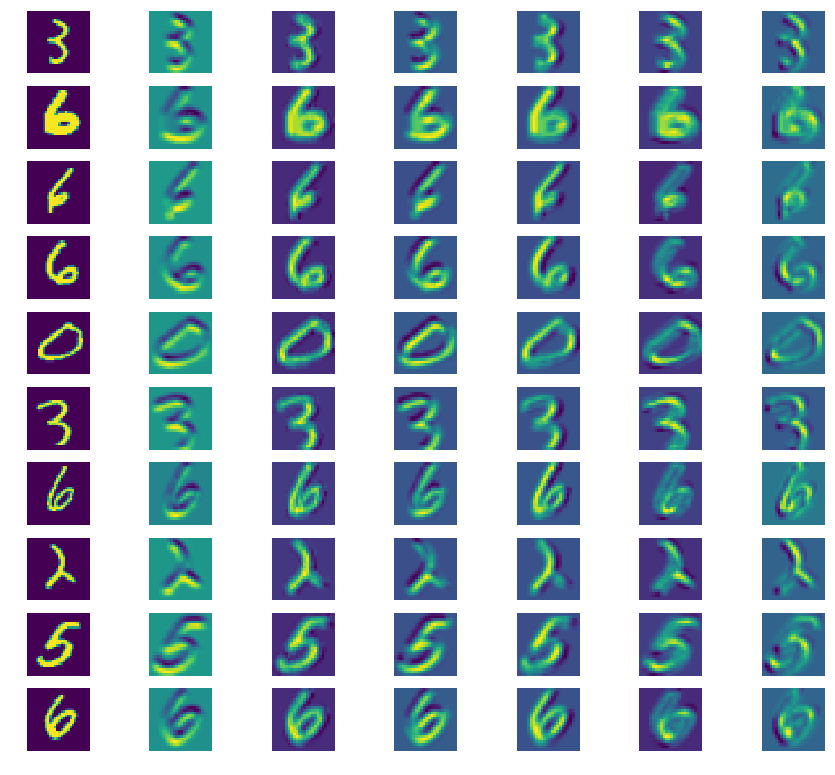

In [76]:
plot(x, y)

Затем визуализируйте результат применения второго сверточного слоя (после всех предыдущих слоев):

In [77]:
### your code here
cnn.eval()
y1 = F.relu(cnn.conv1(x))
y2 = F.max_pool2d(y1, 2)
y = cnn.conv2(y2)

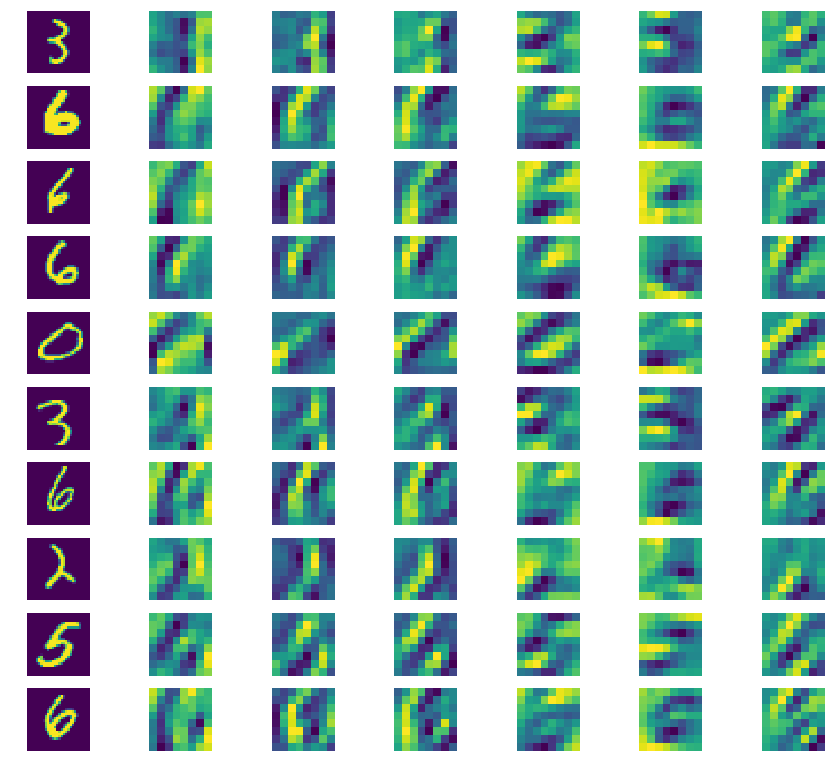

In [78]:
plot(x, y)


### Подбор длины шага и размера батча

Постройте графики точности (accuracy) на обучающей и валидационной выборке в зависимости от номера эпохи при разных параметрах обучения: learning rate$ \in \{0.0001, 0.001, 0.01\}$, batch size $\in \{64, 256\}$. 

Лучше всего отображать кривые для обучения на левом графике, кривые для валидации - на правом с общей осью y (plt.ylim).

Как влияют длина шага и размер батча на итоговое качество?

Epoch [1/50], Loss (train/test): 2.2987/2.3003, Acc (train/test): 0.0887/0.0760
Epoch [2/50], Loss (train/test): 2.2857/2.2878, Acc (train/test): 0.0920/0.0773
Epoch [3/50], Loss (train/test): 2.2611/2.2640, Acc (train/test): 0.2420/0.2173
Epoch [4/50], Loss (train/test): 2.2175/2.2213, Acc (train/test): 0.4013/0.3673
Epoch [5/50], Loss (train/test): 2.1406/2.1457, Acc (train/test): 0.4287/0.3887
Epoch [6/50], Loss (train/test): 2.0209/2.0275, Acc (train/test): 0.4667/0.4533
Epoch [7/50], Loss (train/test): 1.8547/1.8634, Acc (train/test): 0.5267/0.5173
Epoch [8/50], Loss (train/test): 1.6483/1.6607, Acc (train/test): 0.6213/0.6193
Epoch [9/50], Loss (train/test): 1.4164/1.4340, Acc (train/test): 0.6820/0.6893
Epoch [10/50], Loss (train/test): 1.1932/1.2169, Acc (train/test): 0.7200/0.7253
Epoch [11/50], Loss (train/test): 1.0124/1.0427, Acc (train/test): 0.7420/0.7400
Epoch [12/50], Loss (train/test): 0.8767/0.9120, Acc (train/test): 0.7640/0.7593
Epoch [13/50], Loss (train/test): 0.7

Epoch [3/50], Loss (train/test): 0.5669/0.6257, Acc (train/test): 0.8153/0.7993
Epoch [4/50], Loss (train/test): 0.4212/0.5032, Acc (train/test): 0.8827/0.8580
Epoch [5/50], Loss (train/test): 0.3395/0.4263, Acc (train/test): 0.9007/0.8873
Epoch [6/50], Loss (train/test): 0.2848/0.3791, Acc (train/test): 0.9133/0.8927
Epoch [7/50], Loss (train/test): 0.2481/0.3371, Acc (train/test): 0.9240/0.9033
Epoch [8/50], Loss (train/test): 0.2196/0.3135, Acc (train/test): 0.9300/0.9120
Epoch [9/50], Loss (train/test): 0.2038/0.3061, Acc (train/test): 0.9367/0.9147
Epoch [10/50], Loss (train/test): 0.1855/0.3022, Acc (train/test): 0.9407/0.9193
Epoch [11/50], Loss (train/test): 0.1634/0.2919, Acc (train/test): 0.9473/0.9220
Epoch [12/50], Loss (train/test): 0.1285/0.2666, Acc (train/test): 0.9593/0.9293
Epoch [13/50], Loss (train/test): 0.1002/0.2500, Acc (train/test): 0.9700/0.9360
Epoch [14/50], Loss (train/test): 0.0850/0.2463, Acc (train/test): 0.9753/0.9380
Epoch [15/50], Loss (train/test): 0

Epoch [5/50], Loss (train/test): 0.1070/0.3159, Acc (train/test): 0.9627/0.9040
Epoch [6/50], Loss (train/test): 0.0790/0.2852, Acc (train/test): 0.9713/0.9173
Epoch [7/50], Loss (train/test): 0.0949/0.3566, Acc (train/test): 0.9660/0.9160
Epoch [8/50], Loss (train/test): 0.0776/0.3170, Acc (train/test): 0.9760/0.9167
Epoch [9/50], Loss (train/test): 0.0155/0.2649, Acc (train/test): 0.9947/0.9447
Epoch [10/50], Loss (train/test): 0.0350/0.3128, Acc (train/test): 0.9873/0.9380
Epoch [11/50], Loss (train/test): 0.0195/0.2840, Acc (train/test): 0.9933/0.9340
Epoch [12/50], Loss (train/test): 0.0101/0.2729, Acc (train/test): 0.9967/0.9487
Epoch [13/50], Loss (train/test): 0.0159/0.3166, Acc (train/test): 0.9973/0.9373
Epoch [14/50], Loss (train/test): 0.0260/0.4244, Acc (train/test): 0.9907/0.9280
Epoch [15/50], Loss (train/test): 0.0142/0.2976, Acc (train/test): 0.9967/0.9327
Epoch [16/50], Loss (train/test): 0.0027/0.2948, Acc (train/test): 0.9993/0.9460
Epoch [17/50], Loss (train/test):

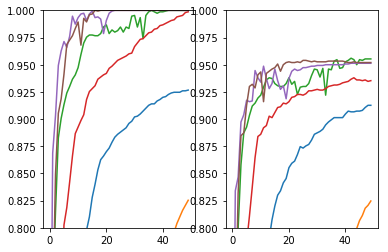

In [85]:
### your code here
learning_rate = [0.0001, 0.001, 0.01]
batch_size = [64, 256]
num_epochs = 50

for lr in learning_rate:
    for batch in batch_size:
        cnn = CNN()
        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
        # for validation purposes:
        train_loader = get_loader(X_train[:1500], y_train[:1500], batch_size=batch)
        val_loader = get_loader(X_train[1500:3000], y_train[1500:3000], batch_size=batch)
        
        _, train_acc_log, _, val_acc_log = train(cnn, optimizer, train_loader, \
                                                               val_loader, criterion, num_epochs, \
                                                               device, verbose=True)
        plt.subplot(1,2,1)
        plt.plot(range(num_epochs), train_acc_log)
        plt.ylim(0.8, 1)
        plt.subplot(1,2,2)
        plt.plot(range(num_epochs), val_acc_log)
        plt.ylim(0.8, 1)

### Изменение архитектуры

Попробуйте модифицировать архитектуру нейросети: увеличить число фильтров и уменьшить число полносвязных слоев. 

Впишите цифры в скобки:
* LeNet-5 классич. (6 и 16 сверток):  качество на обучении: ( )  качество на валидации: ( )
* Увеличение в 4 раза (24 и 64 сверток):  качество на обучении: ( )  качество на валидации: ( )
* Удаление полносвзяного слоя: предыдущая нейросеть с 1 полносвязным слоем: качество на обучении: ( )  качество на валидации: ( )
    
    

In [ ]:
### your code here

Выберите длину шага, размер батча и архитектуру по валидационной выборке, обучите нейросеть на полной обучающей выборке и выведите качество на контрольной выборке. Хуже ли оно, чем на валидационной выборке?